# Clasificador Binario

## Librerías

In [1]:
!pip install fastai -Uq

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     |████████████████████████████████| 197 kB 34.6 MB/s 
     |████████████████████████████████| 59 kB 7.6 MB/s 


{'restart': True, 'status': 'ok'}

In [3]:
from fastai.vision.all import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [4]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 -O train.zip

--2022-05-19 06:56:37--  https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/o1eaoae59qgdo4i/Training_Set_Pre.zip [following]
--2022-05-19 06:56:37--  https://www.dropbox.com/s/raw/o1eaoae59qgdo4i/Training_Set_Pre.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4d7053351325a3a7ce8800e051.dl.dropboxusercontent.com/cd/0/inline/Blifj5rgkHcvTFM13uaYMYpMASPk-OlhuIfG3IO5x3Q6mn_CxTUqUHOtCMHmKhIAEnFGxLzhIe4gHi4iXC7g5DxqxjKmM2gcvTCyXpA1wy8Yru7W0Ad2AYqWQ3-LhVENwJxyxapj4BqSUlcA7af_1GCAIj18xp-v9udWZez2gmCfrQ/file# [following]
--2022-05-19 06:56:38--  https://uc4d7053351325a3a7ce8800e051.dl.dropboxusercontent.com/cd/0/inline/Blifj5rgkHcvTFM13uaYMYpMASPk-OlhuIfG

In [5]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose

Tenemos que cambiar la estructura del dataset


```.
└── dataset
    ├── train
    │   ├── normal
    │   └── enfermedad
    ├── test
    │   ├── normal
    │   └── enfermedad
    └── validation
        ├── normal
        └── enfermedad
```

Para ello usaremos el archivo csv de cada conjunto para mover cada imagen a donde corresponda

In [6]:
#Train Normal y Enfermedad
trainN='dataset/train/normal'
trainE='dataset/train/enfermedad'

test='dataset/test'
val='dataset/val'

!mkdir dataset
!mkdir dataset/train
!mkdir "$trainN"
!mkdir "$trainE"

!mkdir "$test"
!mkdir "$val"

Creamos un path que apunte a la carpeta donde vamos a tener el dataset estructurado posteriormente:

In [27]:
path = Path('dataset/')

In [7]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [8]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')

In [9]:
#1519 tienen enfermedad y 401 no la tienen
df_train['Disease_Risk'].value_counts()

1    1519
0     401
Name: Disease_Risk, dtype: int64

Creamos la estructura mencionada antes

In [10]:
import shutil
for id,enf in zip(df_train['ID'], df_train['Disease_Risk']):
    if(int(enf)==0):
        shutil.copy(str(trainPath)+'/Training/' + str(id) + '.png', trainN)
    else:
        shutil.copy(str(trainPath)+'/Training/' + str(id) + '.png', trainE)      

In [ ]:
len(Path(trainPath/'Training').ls()) #1921
len(Path(testPath/'Test').ls())      #640
len(Path(valPath/'Validation').ls()) #640

Ahora que ya tenemos la estructura deseado empezamos a construir el modelo:

In [12]:
trainPath = Path('dataset/train')

## Cargando el dataset

In [13]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [14]:
dls = db.dataloaders(trainPath,bs=128)

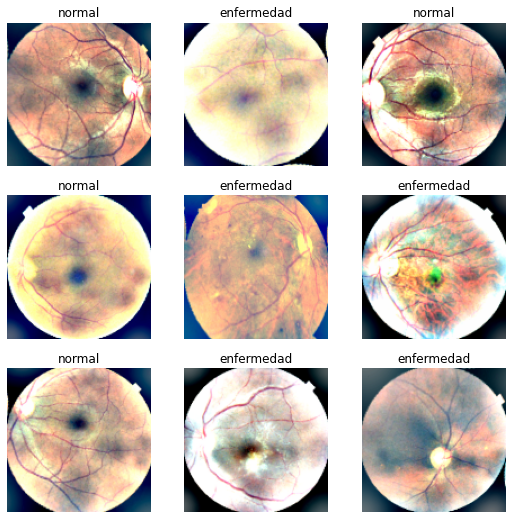

In [15]:
dls.show_batch()

In [17]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=8),
    SaveModelCallback(fname='modelResnet18')  
]

In [18]:
learn = cnn_learner(dls,resnet18,metrics=accuracy,cbs=callbacks).to_fp16()


/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(minimum=0.017378008365631102, steep=0.0002754228771664202, valley=0.0014454397605732083, slide=0.007585775572806597)

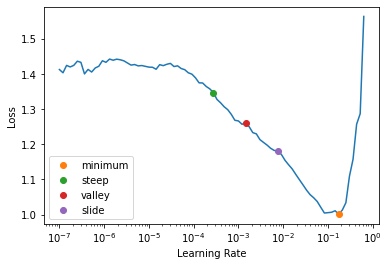

In [19]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,accuracy,time
0,0.213385,0.323939,0.888021,00:07


Better model found at epoch 0 with valid_loss value: 0.3239387571811676.


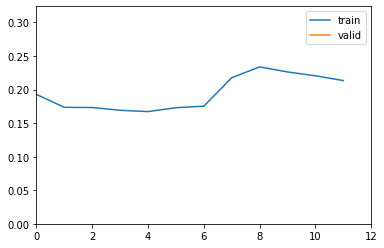

epoch,train_loss,valid_loss,accuracy,time
0,0.275439,0.780931,0.776042,00:07
1,0.235932,0.407977,0.861979,00:07
2,0.214964,0.536725,0.809896,00:07
3,0.194668,0.672714,0.757812,00:07
4,0.188011,0.406822,0.864583,00:07
5,0.183052,0.666632,0.799479,00:07
6,0.195606,0.524798,0.804688,00:07
7,0.190367,1.085691,0.802083,00:07
8,0.184714,0.749839,0.786458,00:07
9,0.189166,0.310074,0.872396,00:07


Better model found at epoch 0 with valid_loss value: 0.7809314727783203.


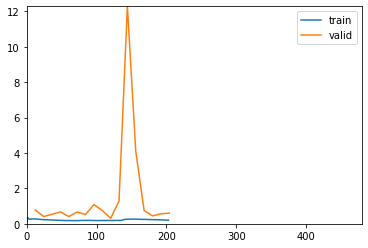

Better model found at epoch 1 with valid_loss value: 0.4079773724079132.
Better model found at epoch 4 with valid_loss value: 0.40682244300842285.
Better model found at epoch 9 with valid_loss value: 0.3100736439228058.
No improvement since epoch 9: early stopping


In [21]:
learn.fine_tune(40,base_lr=1e-1)

Exportamos el modelo

In [24]:
learn.to_fp32()
learn.export('modeloBinario.pkl')

In [25]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.875.


(#2) [0.3099287450313568,0.875]

## Evaluando el modelo

In [28]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [29]:
learn.dls = dlsTest

In [ ]:
learn.validate()